In [0]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from dateutil.relativedelta import relativedelta

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

plt.rcParams['figure.facecolor'] = 'w'


# Load Data

In [0]:
url = 'https://pomber.github.io/covid19/timeseries.json'

In [0]:
response = requests.get(url)

In [0]:
json = response.json()

# EDA

In [0]:
pd.DataFrame(json).head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Diamond Princess,...,Tanzania,Thailand,Togo,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Kosovo,Burma,MS Zaandam,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 548, 'death...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...",...,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 2, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 1, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'.

In [0]:
countries = json.keys()
df_array = []

Convert dataframe to long-format

In [0]:
for country in countries:
  stats = json[country]
  for stat in stats:
    # build row
    date = stat['date']
    confirmed = stat['confirmed']
    deaths = stat['deaths']
    recovered = stat['recovered']
    df_array.append([country, date, confirmed, deaths, recovered])

In [0]:
df = pd.DataFrame(df_array)

In [0]:
df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered'] ; df.head()

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-1-22,0,0,0
1,Afghanistan,2020-1-23,0,0,0
2,Afghanistan,2020-1-24,0,0,0
3,Afghanistan,2020-1-25,0,0,0
4,Afghanistan,2020-1-26,0,0,0


In [0]:
# Convert to datetime object
df['date'] = pd.to_datetime(df['date'])

In [0]:
# Get last date
df['date'].max()

Timestamp('2020-04-15 00:00:00')

# Description Statistics

In [0]:
last_date_df = df[df['date'] == df['date'].max()]

In [0]:
total_confirmed = last_date_df['confirmed'].sum()
total_deaths = last_date_df['deaths'].sum()
total_recovered = last_date_df['recovered'].sum()
print(total_confirmed, total_deaths, total_recovered)

2056054 134177 511019


In [0]:
def get_totals(df: pd.DataFrame) -> list:
  df = df[df['date'] == df['date'].max()]
  return [df['confirmed'].sum(), df['deaths'].sum(), df['recovered'].sum()]

# Country Infection History

In [0]:
# Look at one country
country = 'Canada'
country_df = df[df['country'] == country]
country_df.head(10)

,country,date,confirmed,deaths,recovered
2380,Canada,2020-01-22,0,0,0
2381,Canada,2020-01-23,0,0,0
2382,Canada,2020-01-24,0,0,0
2383,Canada,2020-01-25,0,0,0
2384,Canada,2020-01-26,1,0,0
2385,Canada,2020-01-27,1,0,0
2386,Canada,2020-01-28,2,0,0
2387,Canada,2020-01-29,2,0,0
2388,Canada,2020-01-30,2,0,0
2389,Canada,2020-01-31,4,0,0


In [0]:
print(get_totals(country_df))

[28208, 1006, 8966]


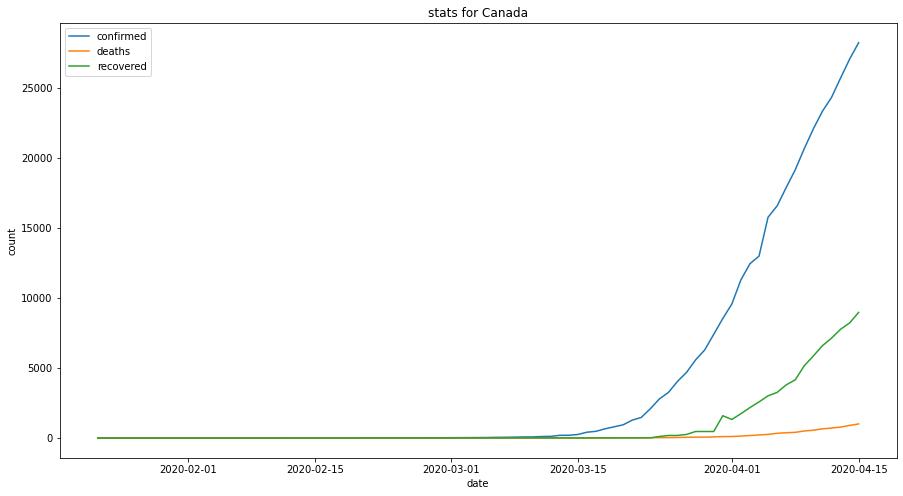

In [0]:
plt.figure(figsize=(15,8))

plt.plot(country_df['date'], country_df['confirmed'], label='confirmed')
plt.plot(country_df['date'],country_df['deaths'], label= 'deaths')
plt.plot(country_df['date'],country_df['recovered'], label = 'recovered')

plt.title(f'stats for {country}')
plt.ylabel('count')
plt.xlabel('date')
plt.legend()

Because of limited data we turn this problem into classification by framing it like a weather forecasting problem as follows:

"Based on data from the past 7 days, what is the number of confirmed cases on the 8th day?"

We frame this similarly for the mortality prediction as well.


# Focus on Canada

In [0]:
country = 'Canada'
canada_df = df[df['country'] == country].copy()
canada_df.reset_index(drop=True,inplace=True)

In [0]:
canada_df.head(10)

,country,date,confirmed,deaths,recovered
0,Canada,2020-01-22,0,0,0
1,Canada,2020-01-23,0,0,0
2,Canada,2020-01-24,0,0,0
3,Canada,2020-01-25,0,0,0
4,Canada,2020-01-26,1,0,0
5,Canada,2020-01-27,1,0,0
6,Canada,2020-01-28,2,0,0
7,Canada,2020-01-29,2,0,0
8,Canada,2020-01-30,2,0,0
9,Canada,2020-01-31,4,0,0


## Some feature engineering

In [0]:
new_confirmed = canada_df['confirmed'].diff()
new_deaths = canada_df['deaths'].diff()

In [0]:
canada_df['new_confirmed'] = new_confirmed
canada_df['new_deaths'] = new_deaths

In [0]:
canada_df.head(10)

,country,date,confirmed,deaths,recovered,new_confirmed,new_deaths
0,Canada,2020-01-22,0,0,0,NaN,NaN
1,Canada,2020-01-23,0,0,0,0.0,0.0
2,Canada,2020-01-24,0,0,0,0.0,0.0
3,Canada,2020-01-25,0,0,0,0.0,0.0
4,Canada,2020-01-26,1,0,0,1.0,0.0
5,Canada,2020-01-27,1,0,0,0.0,0.0
6,Canada,2020-01-28,2,0,0,1.0,0.0
7,Canada,2020-01-29,2,0,0,0.0,0.0
8,Canada,2020-01-30,2,0,0,0.0,0.0
9,Canada,2020-01-31,4,0,0,2.0,0.0


In [0]:
canada_df.tail()

,country,date,confirmed,deaths,recovered,new_confirmed,new_deaths
80,Canada,2020-04-11,23316,654,6589,1257.0,97.0
81,Canada,2020-04-12,24298,714,7123,982.0,60.0
82,Canada,2020-04-13,25679,779,7758,1381.0,65.0
83,Canada,2020-04-14,27034,899,8210,1355.0,120.0
84,Canada,2020-04-15,28208,1006,8966,1174.0,107.0


In [0]:
canada_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   country        85 non-null     object        
 1   date           85 non-null     datetime64[ns]
 2   confirmed      85 non-null     int64         
 3   deaths         85 non-null     int64         
 4   recovered      85 non-null     int64         
 5   new_confirmed  84 non-null     float64       
 6   new_deaths     84 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 4.8+ KB


In [0]:
canada_df.set_index('date', inplace=True)

In [0]:
canada_df.head(10)

,country,confirmed,deaths,recovered,new_confirmed,new_deaths
date,,,,,,
2020-01-22,Canada,0,0,0,NaN,NaN
2020-01-23,Canada,0,0,0,0.0,0.0
2020-01-24,Canada,0,0,0,0.0,0.0
2020-01-25,Canada,0,0,0,0.0,0.0
2020-01-26,Canada,1,0,0,1.0,0.0
2020-01-27,Canada,1,0,0,0.0,0.0
2020-01-28,Canada,2,0,0,1.0,0.0
2020-01-29,Canada,2,0,0,0.0,0.0
2020-01-30,Canada,2,0,0,0.0,0.0


## Data Split

Take data before `2020-04-01` as training while data after as test

In [0]:
forecast_date = '2020-04-01'
train = canada_df.loc[:forecast_date]


In [0]:
train.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [0]:
test = canada_df.drop(train.index)

In [0]:
train.tail()

,country,confirmed,deaths,recovered,new_confirmed,new_deaths
date,,,,,,
2020-03-28,Canada,5576,61,466,894.0,7.0
2020-03-29,Canada,6280,64,466,704.0,3.0
2020-03-30,Canada,7398,80,466,1118.0,16.0
2020-03-31,Canada,8527,101,1592,1129.0,21.0
2020-04-01,Canada,9560,109,1324,1033.0,8.0


In [0]:
test.head()

,country,confirmed,deaths,recovered,new_confirmed,new_deaths
date,,,,,,
2020-04-02,Canada,11284,139,1735,1724.0,30.0
2020-04-03,Canada,12437,179,2175,1153.0,40.0
2020-04-04,Canada,12978,218,2577,541.0,39.0
2020-04-05,Canada,15756,259,3012,2778.0,41.0
2020-04-06,Canada,16563,339,3256,807.0,80.0


In [0]:
#train.reset_index(drop=True, inplace=True)

Want to rearrange the data set to be of the form
```
    | var(t-n) | var(t-(n-1)) | ... | var(t-1) | var(t) |
    ---------------------------------------------------- 
  0 |
  1 |
```
where the far right column is the output forecasting variable (i.e., y) and the columns on its left are the input variables.

In [0]:
"""
PROTOTYPE

temp = canada_df.copy()
target = 'confirmed'
x=[]
y=[]
n_steps = 7
sequence=list(temp[target])
for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    if(seq_y!=0):
        x.append(seq_x)   
        y.append(seq_y)
"""

"\nPROTOTYPE\n\ntemp = canada_df.copy()\ntarget = 'confirmed'\nx=[]\ny=[]\nn_steps = 7\nsequence=list(temp[target])\nfor i in range(len(sequence)):\n    end_ix = i + n_steps\n    if end_ix > len(sequence)-1:\n        break\n    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]\n    if(seq_y!=0):\n        x.append(seq_x)   \n        y.append(seq_y)\n"

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.

  SOURCE: ML Mastery time series tutorial
	"""
  # Determine the number of input variables
  n_vars = 1 if type(data) is list else data.shape[0]
  df = pd.DataFrame(data)
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [0]:
confirmed = canada_df['confirmed'].tolist()

In [0]:
agg = series_to_supervised(confirmed, 7)

In [0]:
agg.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2
8,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2
9,0.0,0.0,1.0,1.0,2.0,2.0,2.0,4
10,0.0,1.0,1.0,2.0,2.0,2.0,4.0,4
11,1.0,1.0,2.0,2.0,2.0,4.0,4.0,4


In [0]:
train_val_c = train['confirmed'].tolist()
test_c = test['confirmed'].tolist()

train_val_d = train['deaths'].tolist()
test_d = test['deaths'].tolist()

In [0]:
test_c

[11284,
 12437,
 12978,
 15756,
 16563,
 17872,
 19141,
 20654,
 22059,
 23316,
 24298,
 25679,
 27034,
 28208]

## Further split train for validation

In [0]:
train_val_c_agg = series_to_supervised(train_val_c, 7)
test_c_agg = series_to_supervised(test_c, 7)

In [0]:
train_val_c_agg.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2
8,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2
9,0.0,0.0,1.0,1.0,2.0,2.0,2.0,4
10,0.0,1.0,1.0,2.0,2.0,2.0,4.0,4
11,1.0,1.0,2.0,2.0,2.0,4.0,4.0,4


In [0]:
test_c_agg

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,11284.0,12437.0,12978.0,15756.0,16563.0,17872.0,19141.0,20654
8,12437.0,12978.0,15756.0,16563.0,17872.0,19141.0,20654.0,22059
9,12978.0,15756.0,16563.0,17872.0,19141.0,20654.0,22059.0,23316
10,15756.0,16563.0,17872.0,19141.0,20654.0,22059.0,23316.0,24298
11,16563.0,17872.0,19141.0,20654.0,22059.0,23316.0,24298.0,25679
12,17872.0,19141.0,20654.0,22059.0,23316.0,24298.0,25679.0,27034
13,19141.0,20654.0,22059.0,23316.0,24298.0,25679.0,27034.0,28208


In [0]:
X_tv_c = train_val_c_agg.drop(columns=['var1(t)']).to_numpy()
y_tv_c = train_val_c_agg['var1(t)'].to_numpy()

In [0]:
X_test_c = test_c_agg.drop(columns=['var1(t)']).to_numpy()
y_test_c = test_c_agg['var1(t)'].to_numpy()

## Reshape for LSTM

Must be in the form:

```[samples, timesteps, features]```

In [0]:
X_tv_c = X_tv_c.reshape((X_tv_c.shape[0], 1, X_tv_c.shape[1]))
X_test_c = X_test_c.reshape((X_test_c.shape[0], 1, X_test_c.shape[1]))

In [0]:
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_tv_c, y_tv_c, test_size=0.2, random_state=42)

In [0]:
y_train_c.shape

(51,)

In [0]:
X_train_c.shape

(51, 1, 7)

In [0]:
y_val_c.shape

(13,)

In [0]:
X_test_c.shape

(7, 1, 7)

# Model Preparation

In [0]:
# Initializing model components
epochs = 25
batch_size = 16
n_hidden = 32
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features=1
n_steps=7
print(timesteps)
print(input_dim)
print(len(X_train_c))

1
7
51


In [0]:

# define model

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_features, n_steps)))
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                11600     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


# Model fit

In [0]:
# fit model
model.fit(X_train_c, y_train_c, epochs=epochs, validation_data=(X_val_c, y_val_c), verbose=2)

Train on 51 samples, validate on 13 samples
Epoch 1/25
 - 0s - loss: 10.6073 - val_loss: 10.4422
Epoch 2/25
 - 0s - loss: 8.9977 - val_loss: 8.8796
Epoch 3/25
 - 0s - loss: 7.6542 - val_loss: 7.6799
Epoch 4/25
 - 0s - loss: 6.7350 - val_loss: 6.8047
Epoch 5/25
 - 0s - loss: 6.0218 - val_loss: 6.1066
Epoch 6/25
 - 0s - loss: 5.4120 - val_loss: 5.5029
Epoch 7/25
 - 0s - loss: 4.8825 - val_loss: 4.9505
Epoch 8/25
 - 0s - loss: 4.4205 - val_loss: 4.4313
Epoch 9/25
 - 0s - loss: 3.9306 - val_loss: 3.9801
Epoch 10/25
 - 0s - loss: 3.3481 - val_loss: 3.3131
Epoch 11/25
 - 0s - loss: 2.8218 - val_loss: 2.4165
Epoch 12/25
 - 0s - loss: 2.2759 - val_loss: 1.9918
Epoch 13/25
 - 0s - loss: 1.9364 - val_loss: 1.7538
Epoch 14/25
 - 0s - loss: 1.6776 - val_loss: 1.4803
Epoch 15/25
 - 0s - loss: 1.4466 - val_loss: 1.2771
Epoch 16/25
 - 0s - loss: 1.2584 - val_loss: 1.1364
Epoch 17/25
 - 0s - loss: 1.0862 - val_loss: 0.9815
Epoch 18/25
 - 0s - loss: 0.9053 - val_loss: 0.8683
Epoch 19/25
 - 0s - loss: 0

# Forecasting

In [0]:
def forecast(model,data,start_date,n_days, n_steps=7):
  """
	Produce a forecast prediction.
	Arguments:
		model: Trained model for the forecasting
		start_date: starting date for the forecast
		n_days: Number of days to forecast after start_date.
		n_steps: Number of days to use for forecast
	Returns:
		Pandas DataFrame of series framed with forecasting results.

  SOURCE: ML Mastery time series tutorial
	"""
  res=dict()
  
  for i in range(len(data)):
      res[i]=[]
  y_pred=model.predict(data)
  dates=[]
  data_window = data.copy()  # Make a copy
  date1 = pd.datetime.datetime.strptime(start_date, "%Y-%m-%d")
  for j in range(1,n_days+1):
      for i in range(len(data_window)):
          cur_window=list(data_window[i][0][1:n_steps+1])
          #print(j,i,cur_window[-1])
          res[i].append(cur_window[-1])
          cur_window.append(y_pred[i])
          data_window[i][0]=cur_window
      y_pred=model.predict(data_window)
      dates.append(date1.strftime("%Y-%m-%d"))
      date1+=relativedelta(days=1)

  res=pd.DataFrame(res).T 
  #print(res)
  res.columns=dates
  #res['Country/State']=regs
  return res

In [0]:
r = forecast(model, X_test_c, forecast_date, 5, 7)

In [0]:
r

,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05
0,19141.0,21214.328125,21881.615234,24762.929688,26912.847656
1,20654.0,21786.556641,24583.597656,26728.384766,29012.414062
2,22059.0,24637.343750,26817.060547,29104.552734,31603.583984
3,23316.0,30180.730469,29389.445312,32336.396484,33369.433594
4,24298.0,32072.970703,31179.933594,34253.593750,35306.937500
5,25679.0,34035.187500,32982.082031,40867.273438,38130.074219
6,27034.0,35967.593750,34770.425781,43127.320312,40223.382812
